# POC: Acceleration Estimation Smoothing with Multiple Exogenous Noise Sources and Long Term Drift

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint

## Synthetic Data

In [23]:
# Example usage
AMPLITUDE = 1.0
FREQUENCY = 2.0
DAMPING_FACTOR = 0.1
TIME_START = 0.0
TIME_END = 10.0
NUM_SAMPLES = 15360


#RNN and LSTM parameters
SEQUENCE_LENGTH = 128

In [24]:
def generate(noise_std=0.0):
    time = np.linspace(TIME_START, TIME_END, NUM_SAMPLES)
    angular_frequency = 2 * np.pi * FREQUENCY
    exponential_decay = np.exp(-DAMPING_FACTOR * time)
    oscillation = AMPLITUDE * np.cos(angular_frequency * time)
    if noise_std > 0.0:
        noise = np.random.normal(0, noise_std, NUM_SAMPLES)
        data = oscillation * exponential_decay + noise
    else:
        data = oscillation * exponential_decay

    return time, data

# Run the simulation
time, positions = generate(0.1)
time, ground_truth= generate()

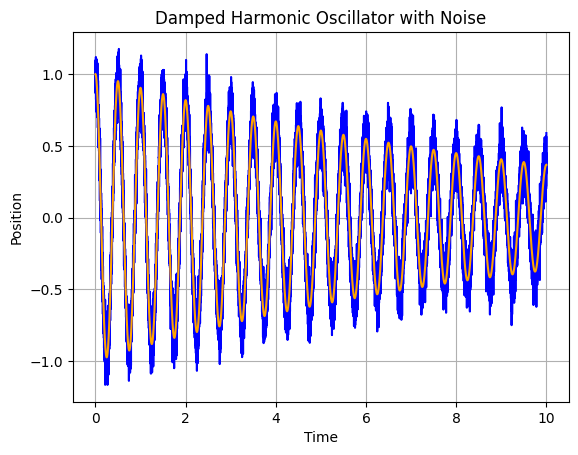

In [25]:
# Plot the results
plt.plot(time, positions, color='blue', label='Noisy')
plt.plot(time, ground_truth, color='orange', label='Ground Truth')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator with Noise')
plt.grid(True)
plt.show()

In [26]:
import torch
import torch.nn as nn
# Define the loss function
criterion = nn.MSELoss()

## Kalman Filter

In [27]:
from filterpy.kalman import KalmanFilter
import numpy as np

kf = KalmanFilter(dim_x=1, dim_z=1)

# state transition matrix
kf.F = np.array([[1.]])
# measurement function matrix
kf.H = np.array([[1.]])
# covariance matrix // process noise
kf.Q = np.array([[0.1]])
# covariance matrix // measurement noise 
kf.R = np.array([[1.]])
# initialize state
kf.x = np.array([[0.]])
# initialize covariance matrix 
kf.P = np.array([[1.]])

# Perform the filtering
filtered_positions = []
for position in positions:
    kf.predict()
    kf.update(position)
    filtered_positions.append(kf.x[0, 0 ])

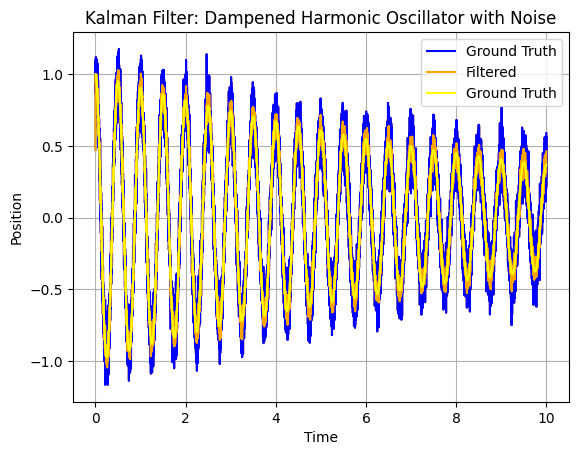

In [28]:
plt.plot(time, filtered_positions)
plt.plot(time, positions)

# Plot the lines with labels
plt.plot(time, positions, color='blue', label='Ground Truth')
plt.plot(time, filtered_positions, color='orange', label='Filtered')
plt.plot(time, ground_truth, color='yellow', label='Ground Truth')


# Add legend
plt.legend()

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Kalman Filter: Dampened Harmonic Oscillator with Noise')
plt.grid(True)
plt.show()

In [29]:
#tensorify everything

filtered = torch.tensor(filtered_positions, dtype=torch.float32).unsqueeze(1)
gt = torch.tensor(ground_truth, dtype=torch.float32).unsqueeze(1)

data = torch.tensor(positions, dtype=torch.float32).unsqueeze(1)

In [30]:
criterion(filtered, gt)

tensor(0.0017)

In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
import torch.nn.functional as F

class RNNAutoencoder(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, encoder_dim, n_layers, batch_size, dropout=0.5):
        super(RNNAutoencoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.criterion = nn.MSELoss(reduction='mean')
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # encoder layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)#, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim, encoder_dim)
        self.lstm1 = self.lstm1.to(device)

        # decoder layers
        self.fc2 = nn.Linear(encoder_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, input_dim, n_layers, dropout=dropout, batch_first=True)
        
        self.hidden1, self.hidden2 = self.init_hidden(batch_size)


    def forward(self, x):
        batch_size = x.size(0)
        self.hidden1 = tuple([each.data for each in self.hidden1])
        self.hidden2 = tuple([each.data for each in self.hidden2])
        opt = self.optimizers()
        opt.zero_grad()

        # decode
        lstm_dec, hidden1 = self.lstm1(x, self.hidden1)
        lstm_dec = lstm_dec.contiguous().view(-1, self.hidden_dim)
        dec = self.dropout(lstm_dec)
        dec = F.relu(self.fc1(dec))

        # encode
        enc = F.relu(self.fc2(dec))
        enc = self.dropout(enc)

        lstm_enc = enc.view(batch_size, -1, self.hidden_dim)
        lstm_enc, hidden2 = self.lstm2(lstm_enc, self.hidden2)
        
        
        self.hidden1 = hidden1
        self.hidden2 = hidden2

        return lstm_enc
    
    def validation_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = criterion(reconstructed, x)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = criterion(reconstructed, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def init_hidden(self, batch_size, gpu=True):
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        hidden2 = (weight.new(self.n_layers, batch_size, self.input_dim).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.input_dim).zero_().to(self.device))
        return hidden1, hidden2


#make this work for even-sized batches or enforce some other way
train_size = int(0.75 * len(positions))
test_size = len(positions) - train_size

def partition_tensor(tensor, k):
    num_samples = tensor.shape[0]

    # Determine the number of samples in each fold
    samples_per_fold = num_samples // k

    # Partition the tensor into k folds
    folds = torch.split(tensor[:k*samples_per_fold], samples_per_fold)

    return folds

#ground truth, 0.75 of observations
train_set = torch.stack(partition_tensor(gt[:train_size], 64))
#real-world, 0.25 (tail) of observations
val_set = torch.stack(partition_tensor(data[- (len(positions) - train_size):], 64))


model_chkpt = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    dirpath='saved_models',
    filename='best_model'
)

In [141]:
class Dataset(pl.LightningDataModule):
    def __init__(self, train, val, batch_size=8):
        super().__init__()
        self.train = train
        self.val = val 
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_set = TensorDataset(self.train)
        self.val_set = TensorDataset(self.val)

    def train_dataloader(self):
        return DataLoader(self.train ,batch_size=self.batch_size, shuffle=False,num_workers=8 )
    
    def val_dataloader(self):
        return DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=8)

In [142]:
data_module = Dataset(train_set, val_set)





# Instantiate the LSTM Autoencoder
n_layers =  1
hidden_size = 32
input_size = 1
encoder_size = 64
rnn_ae = RNNAutoencoder(input_size, hidden_size, encoder_size,  n_layers, 8)

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(accelerator='cpu',  max_epochs=50, devices=1, callbacks= [model_chkpt])  # Set the desired number of epochs and number of GPUs

# Start the training
trainer.fit(rnn_ae, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | dropout   | Dropout | 0     
1 | criterion | MSELoss | 0     
2 | lstm1     | LSTM    | 4.5 K 
3 | fc1       | Linear  | 2.1 K 
4 | fc2       | Linear  | 2.1 K 
5 | lstm2     | LSTM    | 140   
--------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████| 8/8 [00:01<00:00,  4.28it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████████████████| 8/8 [00:02<00:00,  3.10it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████████████████| 8/8 [00:02<00:00,  2.85it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████████████████| 8/8 [00:03<00:00,  2.18it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████| 8/8 [00:02<00:00,  3.00it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████████████████████| 8/8 [00:02<00:00,  3.07it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████████████████| 8/8 [00:02<00:00,  2.96it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████████████████████| 8/8 [00:02<00:00,  3.10it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|█████████████████████████| 8/8 [00:02<00:00,  3.08it/s, v_num=120]
Validation: 0it [00:00,

Epoch 9: 100%|█████████████████████████| 8/8 [00:02<00:00,  2.73it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|████████████████████████| 8/8 [00:02<00:00,  2.77it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|████████████████████████| 8/8 [00:02<00:00,  2.77it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|████████████████████████| 8/8 [00:02<00:00,  3.07it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|████████████████████████| 8/8 [00:02<00:00,  3.28it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|████████████████████████| 8/8 [00:02<00:00,  3.36it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████████| 8/8 [00:02<00:00,  3.29it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|████████████████████████| 8/8 [00:02<00:00,  3.07it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|████████████████████████| 8/8 [00:04<00:00,  1.65it/s, v_num=120]


Epoch 17: 100%|████████████████████████| 8/8 [00:02<00:00,  3.39it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|████████████████████████| 8/8 [00:02<00:00,  3.24it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|████████████████████████| 8/8 [00:02<00:00,  3.21it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|████████████████████████| 8/8 [00:02<00:00,  2.99it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|████████████████████████| 8/8 [00:02<00:00,  3.14it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|████████████████████████| 8/8 [00:02<00:00,  3.33it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|████████████████████████| 8/8 [00:02<00:00,  3.42it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|████████████████████████| 8/8 [00:02<00:00,  3.40it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|████████████████████████| 8/8 [00:02<00:00,  3.27it/s, v_num=120]
Validation: 0it [00:00,

Epoch 26: 100%|████████████████████████| 8/8 [00:02<00:00,  3.27it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|████████████████████████| 8/8 [00:02<00:00,  3.20it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████████████████| 8/8 [00:02<00:00,  3.18it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|████████████████████████| 8/8 [00:02<00:00,  3.18it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|████████████████████████| 8/8 [00:02<00:00,  3.20it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|████████████████████████| 8/8 [00:02<00:00,  3.07it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|████████████████████████| 8/8 [00:02<00:00,  3.03it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|████████████████████████| 8/8 [00:02<00:00,  3.13it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|████████████████████████| 8/8 [00:04<00:00,  1.63it/s, v_num=120]


Epoch 34: 100%|████████████████████████| 8/8 [00:02<00:00,  3.15it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|████████████████████████| 8/8 [00:02<00:00,  3.25it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|████████████████████████| 8/8 [00:02<00:00,  3.03it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|████████████████████████| 8/8 [00:02<00:00,  2.88it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|████████████████████████| 8/8 [00:02<00:00,  3.19it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|████████████████████████| 8/8 [00:02<00:00,  3.06it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|████████████████████████| 8/8 [00:02<00:00,  2.82it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|████████████████████████| 8/8 [00:02<00:00,  3.09it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|████████████████████████| 8/8 [00:02<00:00,  3.11it/s, v_num=120]
Validation: 0it [00:00,

Epoch 43: 100%|████████████████████████| 8/8 [00:02<00:00,  3.13it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|████████████████████████| 8/8 [00:02<00:00,  3.04it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|████████████████████████| 8/8 [00:02<00:00,  3.22it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|████████████████████████| 8/8 [00:02<00:00,  3.03it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|████████████████████████| 8/8 [00:02<00:00,  2.98it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|████████████████████████| 8/8 [00:02<00:00,  3.08it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|████████████████████████| 8/8 [00:02<00:00,  3.14it/s, v_num=120]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|████████████████████████| 8/8 [00:04<00:00,  1.62it/s, v_num=120]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|████████████████████████| 8/8 [00:04<00:00,  1.62it/s, v_num=120]


In [159]:
def test_generalization(gt, ckpt):
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[18, 12])
    noises = [0.01, 0.1, 0.5]

    # Loop through each subplot and plot the data
    for i, ax in enumerate(axes.flatten()):
        noise_val = noises[i]
        time, noisy = generate(noise_val)
        time, gt = generate()
        gt = torch.tensor(gt, dtype =torch.float32).unsqueeze(1)
        test = partition_tensor(torch.tensor(noisy, dtype=torch.float32).unsqueeze(1), 64)
        
        dl = DataLoader(test, batch_size=8, shuffle=False)
        out = trainer.predict(rnn_ae, dataloaders=dl)
        r = torch.cat([o.reshape(-1) for o in out ])
        
        ax.plot(time, noisy, color = 'blue', label = 'Noisy')
        ax.plot(time, r, color = 'orange', label = 'AE Smoothed')
        ax.plot(time, gt, color = 'yellow', label = 'Ground Truth')

        # Add legend
        ax.legend()

        ax.set_xlabel('Time')
        ax.set_ylabel('Position')
        print(r.shape)
        print(gt.shape)
        loss = criterion(r, gt)
        ax.set_title(f'Noise  {noise_val} Loss {loss:.2f}')
        ax.grid(True)


Predicting DataLoader 0: 100%|███████████████████| 8/8 [00:00<00:00, 117.02it/s]


/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15360, 1])) that is different to the input size (torch.Size([15360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([15360])
torch.Size([15360, 1])
Predicting DataLoader 0: 100%|███████████████████| 8/8 [00:00<00:00, 132.24it/s]
torch.Size([15360])
torch.Size([15360, 1])
Predicting DataLoader 0: 100%|███████████████████| 8/8 [00:00<00:00, 126.82it/s]
torch.Size([15360])
torch.Size([15360, 1])


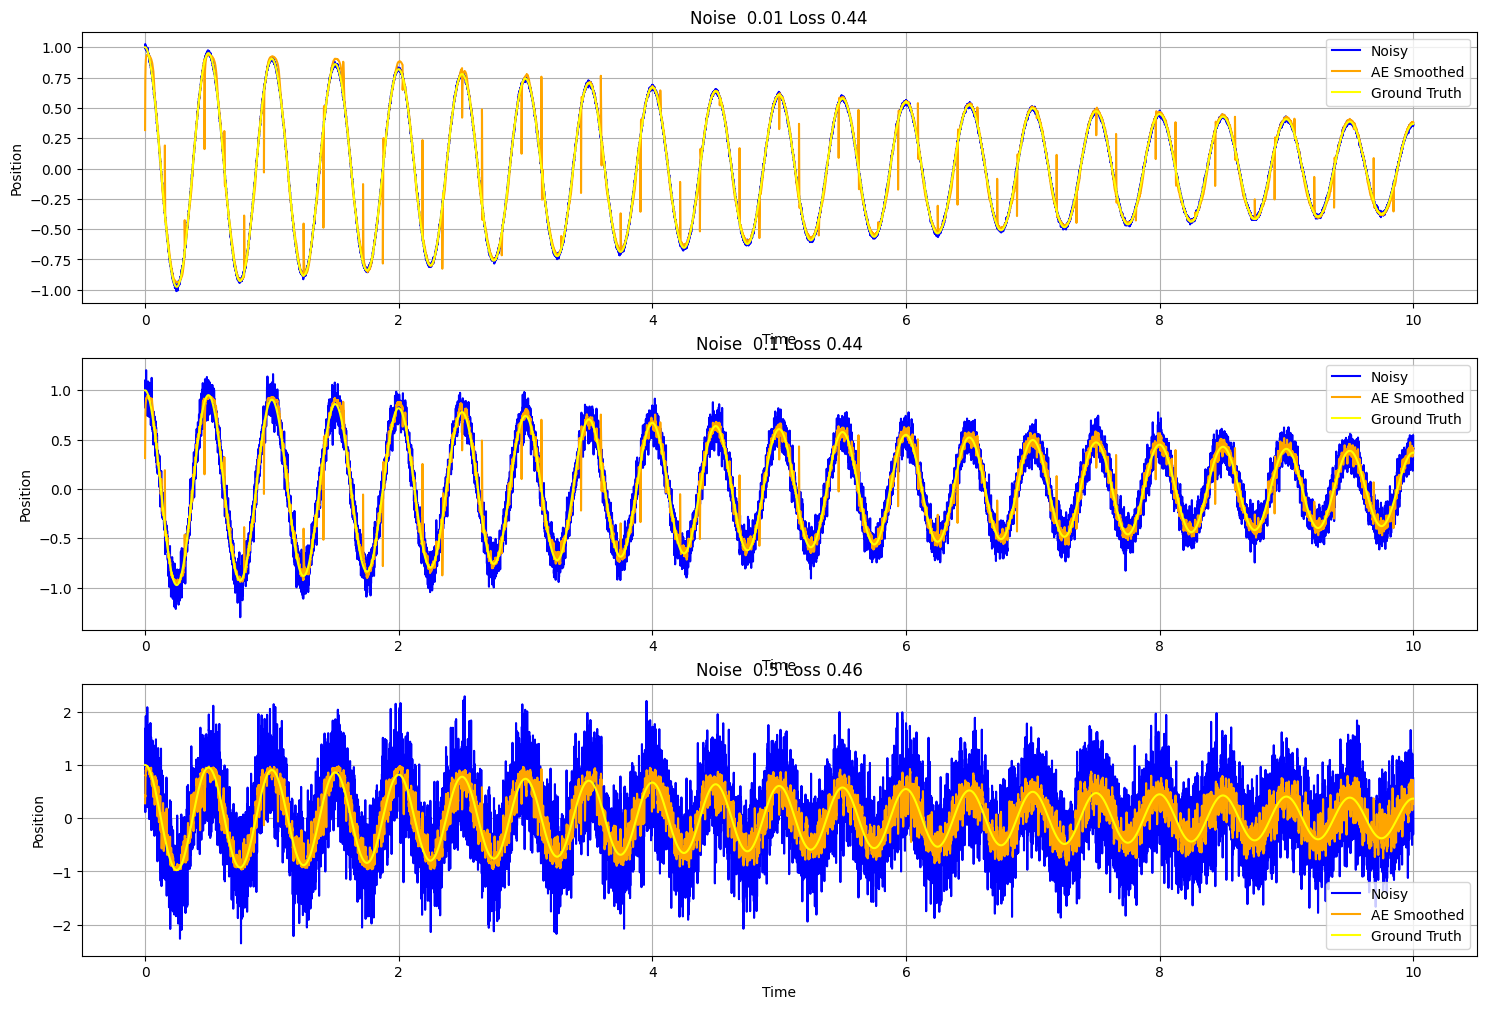

In [160]:
test_generalization(gt, '')